In [39]:
import os
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Dropout, Conv1D, GlobalMaxPooling1D, LSTM, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from keras import backend as K
import tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Followed the step by step from https://www.kaggle.com/general/74235

In [ ]:
! pip install -q kaggle
from google.colab import files 
files.upload() #aqui faz o upload do kaggle.json que voce gerou. Ver link acima.

Download and extract the dataset

In [3]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
if os.path.exists('portuguese-tweets-for-sentiment-analysis.zip') == False:
  !kaggle datasets download -d augustop/portuguese-tweets-for-sentiment-analysis
  !unzip portuguese-tweets-for-sentiment-analysis.zip
  

 97% 217M/224M [00:03<00:00, 92.4MB/s]
100% 224M/224M [00:03<00:00, 69.5MB/s]
Archive:  portuguese-tweets-for-sentiment-analysis.zip
  inflating: NoThemeTweets.csv       
  inflating: TestDatasets/Test.csv   
  inflating: TestDatasets/Test3classes.csv  
  inflating: TestDatasets/TestTema.csv  
  inflating: TrainingDatasets/Train100.csv  
  inflating: TrainingDatasets/Train200.csv  
  inflating: TrainingDatasets/Train300.csv  
  inflating: TrainingDatasets/Train3Classes.csv  
  inflating: TrainingDatasets/Train400.csv  
  inflating: TrainingDatasets/Train50.csv  
  inflating: TrainingDatasets/Train500.csv  
  inflating: TrainingDatasets/TrainTema.csv  
  inflating: TweetsNeutralHash.csv   
  inflating: TweetsNeutralNews.csv   
  inflating: TweetsWithTheme.csv     
  inflating: testdatasets/Test.csv   
  inflating: testdatasets/Test3classes.csv  
  inflating: testdatasets/TestTema.csv  
  inflating: trainingdatasets/Train100.csv  
  inflating: trainingdatasets/Train200.csv  
  inflating:

Visualizar os dados

In [5]:
def load_data(file_train = 'trainingdatasets/Train3Classes.csv', file_test = 'testdatasets/Test3classes.csv'):
    train = pd.read_csv(
        file_train, delimiter=';')

    test = pd.read_csv(
        file_test, delimiter=';')
    
    return train, test

train, test = load_data()
train.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


Separar os dados em treino e teste de acordo com a sugestão do autor

In [6]:
X_train = train.loc[:, 'tweet_text'].values
X_train = pd.Series(X_train)
X_train.rename({0: 'String'}, axis='columns', inplace=True)
y_train = train.loc[:, 'sentiment'].values
y_train = pd.get_dummies(y_train)
y_train = y_train.to_numpy()

X_test = test.loc[:, 'tweet_text'].values
X_test = pd.Series(X_test)
X_test.rename({0: 'String'}, axis='columns', inplace=True)
y_test = test.loc[:, 'sentiment'].values
y_test = pd.get_dummies(y_test)
y_test = y_test.to_numpy()

print("X_train:", X_train['String'])
print("y_train:", y_train[0])
print("X_test:", X_test['String'])
print("y_test:", y_test[0])

X_train: @Laranjito76 A pessoa certa para isso seria o vale e azevedo :)
y_train: [0 1 0]
X_test: @Gazo1a Nossa! Muito obrigada :)
y_test: [0 1 0]


Pre-processamento.
Sugestões:
- Remover  dos tweets @nomes, #hashtags, links, pontuações, caracteres especiais como ([/*, 
etc..
- Tokenizar os tweets (pode ser usada a biblioteca tensorflow.keras.preprocessing.text.Tokenizer ou algum módulo para tokenização do [nltk](https://www.nltk.org/api/nltk.tokenize.html))
- Fazer preenchimento da sequencia (pad_sequences) com base no tweet de maior tamanho.

In [7]:
def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [8]:
# Removes special characters, emojis, urls, names and hashtags
X_train = X_train.str.replace(r'@[A-Za-z0-9]+', '')
X_train = X_train.str.replace(r'#[A-Za-z0-9]+', '')
X_train = X_train.str.replace(r'http\S+', '')
X_train = X_train.str.replace(r'[^A-Za-z0-9 ]+', '')
X_train = X_train.str.lower()
X_train = X_train.apply(remove_emoji)
# Creates our corpus (words freq and vocab employed in all tweets in our set)
tweet_words_train = []
for sentence_train in X_train:
  words_train = word_tokenize(sentence_train)
  tweet_words_train.append(words_train)
  qt_of_words_sentence_train = len(sentence_train)
count_words_train = Counter()
for sentence_train in tweet_words_train:
  for word_train in sentence_train:
    count_words_train[word_train] += 1      
total_qt_words = len(count_words_train)
# Tokenizes all sentences
tokenizer = Tokenizer(num_words=total_qt_words)
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
# Pads all sentences
X_train_padded = pad_sequences(X_train_tokenized, padding="post", maxlen=69)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_tokenized, padding="post", maxlen=69)

In [9]:
print(f"Shape of the train set {X_train_padded.shape}")
print(f"Shape of the test set {X_test_padded.shape}")

Shape of the train set (100000, 69)
Shape of the test set (4999, 69)


In [10]:
qt_distinct_words = X_train_padded.shape[1]

Carregar Word Embedding e criar a matriz de word embeddings com base na lista de tokens

In [11]:
'''
#Word Embeddings em português: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

!wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s50.zip
!unzip -o download.php?file=embeddings%2Fglove%2Fglove_s50.zip
'''

'\n#Word Embeddings em português: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc\n\n!wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s50.zip\n!unzip -o download.php?file=embeddings%2Fglove%2Fglove_s50.zip\n'

In [12]:
'''
glove_embeddings_index = {}
with io.open('glove_s50.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0].replace(',', '.')
        coefs = np.asarray(values[1:],dtype='float32')
        glove_embeddings_index[word] = coefs
# Building the weight matrix
'''

"\nglove_embeddings_index = {}\nwith io.open('glove_s50.txt', encoding='utf8') as f:\n    for line in f:\n        values = line.split()\n        word = values[0].replace(',', '.')\n        coefs = np.asarray(values[1:],dtype='float32')\n        glove_embeddings_index[word] = coefs\n# Building the weight matrix\n"

Aqui comeca de fato o modelo. O codigo abaixo e apenas uma sugestao.

In [13]:
'''
model=Sequential()

#insert your model architecture
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=[]) #insert appropriate metrics
model.summary()
'''

"\nmodel=Sequential()\n\n#insert your model architecture\nmodel.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=[]) #insert appropriate metrics\nmodel.summary()\n"

In [29]:
n_classes = len(y_train[0])

In [30]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [49]:
def get_model(optimizer):
  model = Sequential()

  model.add(Embedding(total_qt_words, 32, input_length=qt_distinct_words))
  model.add(LSTM(64, dropout=0.1))
  model.add(Dense(n_classes, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', f1_m, recall_m, precision_m])
  
  model.summary()

  return model

In [50]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = get_model(optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 69, 32)            2059264   
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,084,291
Trainable params: 2,084,291
Non-trainable params: 0
_________________________________________________________________


In [51]:
qt_epochs = 20

In [52]:
hist=model.fit(
    X_train_padded, 
    y_train,
    epochs=qt_epochs
)

Epoch 1/20
3125/3125 [==============================] - 173s 54ms/step - loss: 1.0588 - accuracy: 0.3863 - f1_m: 0.1009 - recall_m: 0.0690 - precision_m: 0.2050
Epoch 2/20
3125/3125 [==============================] - 162s 52ms/step - loss: 0.9328 - accuracy: 0.5411 - f1_m: 0.4262 - recall_m: 0.3512 - precision_m: 0.5968
Epoch 3/20
3125/3125 [==============================] - 163s 52ms/step - loss: 0.9222 - accuracy: 0.5452 - f1_m: 0.5264 - recall_m: 0.5153 - precision_m: 0.5477
Epoch 4/20
3125/3125 [==============================] - 163s 52ms/step - loss: 0.9447 - accuracy: 0.5246 - f1_m: 0.4325 - recall_m: 0.3952 - precision_m: 0.5429
Epoch 5/20
3125/3125 [==============================] - 164s 52ms/step - loss: 0.9443 - accuracy: 0.5250 - f1_m: 0.3887 - recall_m: 0.3315 - precision_m: 0.5608
Epoch 6/20
3125/3125 [==============================] - 163s 52ms/step - loss: 0.9418 - accuracy: 0.5264 - f1_m: 0.3338 - recall_m: 0.2489 - precision_m: 0.6156
Epoch 7/20
3125/3125 [============


Gerar os resultados. 
A variavel hist pode ser usada para plotar as curvas. Para obter as predicoes, usar model.predict(test_batches).
Matrizes de confusao e metricas podem ser facilmente calculadas usando o pacote 
scikit-learn.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


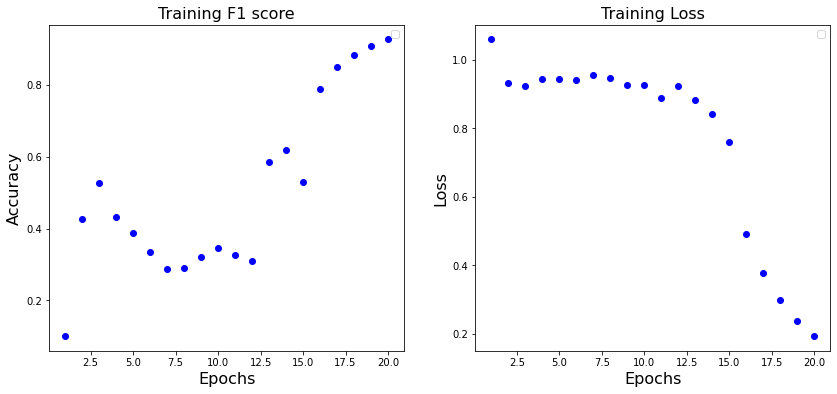

In [53]:
history_dict = hist.history
loss_values = history_dict['loss']
f1 = history_dict['f1_m']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, f1, 'bo')
ax[0].set_title('Training F1 score', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend();

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'bo')
ax[1].set_title('Training Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend();

Confusion Matrix


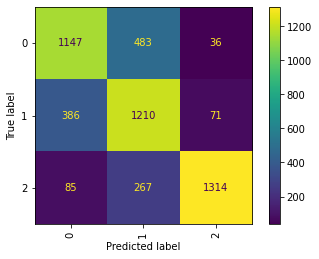

In [54]:
pred = model.predict(X_test_padded)
pred = np.argmax(pred, axis=1)
actual = y_test
actual = np.argmax(actual, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(actual, pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
disp_cm.plot(xticks_rotation='vertical');